## Q2: Face Similarity with Siamese Network (One-shot Learning)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import numpy as np
from PIL import Image
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import random

# ---------- Siamese Dataset ----------
class SiameseFaceDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.class_to_indices = self._build_class_index()

    def _build_class_index(self):
        index = {}
        for i, label in enumerate(self.labels):
            index.setdefault(label, []).append(i)
        return index

    def __getitem__(self, index):
        img1 = self.images[index]
        label1 = self.labels[index]

        if random.random() > 0.2:
            label2 = label1
            idx2 = random.choice(self.class_to_indices[label1])
            target = 1
        else:
            label2 = random.choice([l for l in self.class_to_indices if l != label1])
            idx2 = random.choice(self.class_to_indices[label2])
            target = 0

        img2 = self.images[idx2]

        img1 = self.transform(Image.fromarray(np.uint8(img1)))
        img2 = self.transform(Image.fromarray(np.uint8(img2)))

        return img1, img2, torch.tensor([target], dtype=torch.float32)

    def __len__(self):
        return len(self.images)

# ---------- Siamese Network ----------
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        base_model = models.resnet50(pretrained=True)
        base_model.fc = nn.Linear(base_model.fc.in_features, 128)
        self.model = base_model

    def forward_once(self, x):
        return F.normalize(self.model(x), p=2, dim=1)

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return out1, out2

# ---------- Contrastive Loss ----------
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        dist = F.pairwise_distance(output1, output2)
        loss = 0.5 * (label * dist**2 + (1 - label) * torch.clamp(self.margin - dist, min=0.0)**2)
        return loss.mean()

# ---------- Load Dataset ----------
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.4)
X = lfw_people.images
y = lfw_people.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(3),
    transforms.ToTensor()
])

train_dataset = SiameseFaceDataset(X_train, y_train, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SiameseNet().to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        # Forward pass
        out1, out2 = model(img1, img2)
        loss = criterion(out1, out2, label)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/30], Loss: 0.0899
Epoch [2/30], Loss: 0.0842
Epoch [3/30], Loss: 0.0974
Epoch [4/30], Loss: 0.0959
Epoch [5/30], Loss: 0.0767
Epoch [6/30], Loss: 0.0867
Epoch [7/30], Loss: 0.0851
Epoch [8/30], Loss: 0.0921
Epoch [9/30], Loss: 0.0817
Epoch [10/30], Loss: 0.0917
Epoch [11/30], Loss: 0.0910
Epoch [12/30], Loss: 0.0906
Epoch [13/30], Loss: 0.0936
Epoch [14/30], Loss: 0.0886
Epoch [15/30], Loss: 0.0942
Epoch [16/30], Loss: 0.0841
Epoch [17/30], Loss: 0.0930
Epoch [18/30], Loss: 0.0916
Epoch [19/30], Loss: 0.0922
Epoch [20/30], Loss: 0.0849
Epoch [21/30], Loss: 0.0805
Epoch [22/30], Loss: 0.0778
Epoch [23/30], Loss: 0.0834
Epoch [24/30], Loss: 0.0920
Epoch [25/30], Loss: 0.0901
Epoch [26/30], Loss: 0.0852
Epoch [27/30], Loss: 0.0881
Epoch [28/30], Loss: 0.0875
Epoch [29/30], Loss: 0.0868
Epoch [30/30], Loss: 0.0826


In [5]:
from sklearn.metrics import accuracy_score

test_dataset = SiameseFaceDataset(X_test, y_test, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for img1, img2, label in test_loader:
        out1, out2 = model(img1.to(device), img2.to(device))
        dist = F.pairwise_distance(out1, out2)

        threshold = 0.1
        pred = (dist < threshold).float()
        all_labels.append(label.item())
        all_preds.append(pred.item())


acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc * 100:.2f}%")


Accuracy: 75.00%


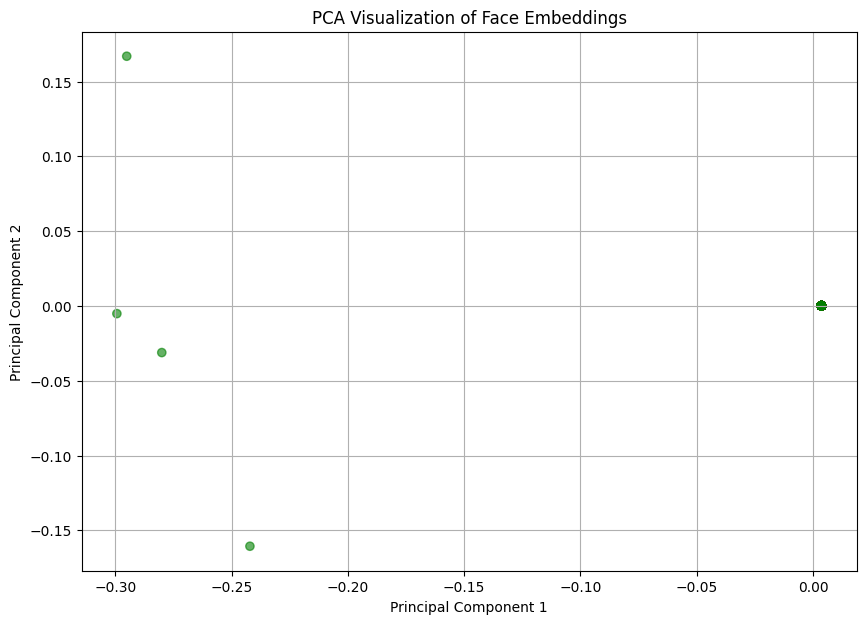

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for img1, img2, label in test_loader:
        img1 = img1.to(device)
        out = model.forward_once(img1)
        embeddings.append(out.squeeze().cpu().numpy())
        labels.append(label.item())
embeddings_np = np.array(embeddings)
labels_np = np.array(labels)

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np)
colors = ['green' if l == 1 else 'red' for l in labels_np]

plt.figure(figsize=(10, 7))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.6)
plt.title("PCA Visualization of Face Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
